In [1]:
from UTILITY_quickstart import *
import yaml

with open('setLattice_defaults.yml', 'r') as file:
    importedDefaultSettings = yaml.safe_load(file)

In [2]:
tao = initializeTao(
    #inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    #inputBeamFilePathSuffix = '/beams/L0AFEND_facet2-lattice.h5',
    inputBeamFilePathSuffix = '/beams/2024-10-14_Impact_TwoBunch/2024-10-14_TwoBunch.h5',

    csrTF = False,
    numMacroParticles=1e5,
    #loadDefaultLatticeTF=False,
)

activeSettings = importedDefaultSettings | {
    "S1EL_xOffset" : 0.00,  
    "S1EL_yOffset" : 0.0,  
    #"S2EL_xOffset" : 0.002,  
    "S2EL_yOffset" : 0.0,  
    "S2ER_xOffset" : 0.0,  
    "S2ER_yOffset" : 0.0,  
    "S1ER_xOffset" : 0.0,  
    "S1ER_yOffset" : 0.0,

    #"XC1FFkG" : 0.2321150061,


    #Sextupole compensated
    "S2EL_xOffset" : 0.002, 
    "XC1FFkG" : 0.19,

}
setLattice(tao, **activeSettings)

#Set aside the initial beam for later reference
trackBeam(tao, trackEnd = "L0BFEND", verbose = True)
PInit = ParticleGroup(data=tao.bunch_data("L0AFEND"))

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_defaults.yml
Number of macro particles = 100000.0
Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = L0BFEND
Tracking!
trackBeam() exiting


In [3]:
trackBeam(tao, centerBC14 = True, centerBC20 = True, verbose = True)

Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = end
Set track_end = BEGBC14_1
Tracking!
Beam centered at BEGBC14 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC14_1, track_end = end
Set track_end = BEGBC20
Tracking!
Beam centered at BEGBC20 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC20, track_end = end
Tracking!
trackBeam() exiting


In [4]:
savedData = {}

P = getBeamAtElement(tao, "PENT")
PDrive, PWitness = getDriverAndWitness(P)


for PActiveStr in ["PDrive", "PWitness"]:
    PActive = locals()[PActiveStr]
    for val in ["mean_x", "mean_y", "sigma_x", "sigma_y", "mean_xp", "mean_yp"]:
        savedData[f"{PActiveStr}_{val}"] = PActive[val]
        #print(f"""{PActiveStr}_{val} = {PActive[val]}""")

    #Note that this is not a standard deviation; also imposes cost for being off zero
    #savedData[f"{PActiveStr}_xCost"] = np.sqrt(np.mean((PActive.x)**2))
    #savedData[f"{PActiveStr}_yCost"] = np.sqrt(np.mean((PActive.y)**2))


    #Using the product was making it report flat beams...
    #savedData[f"{PActiveStr}_totalCost"] = savedData[f"{PActiveStr}_xCost"] * savedData[f"{PActiveStr}_yCost"]
    #Instead, average
    #savedData[f"{PActiveStr}_totalCost"] = 0.5*(savedData[f"{PActiveStr}_xCost"] + savedData[f"{PActiveStr}_yCost"])

    savedData[f"{PActiveStr}_median_x"] = np.median(PActive.x)
    savedData[f"{PActiveStr}_median_y"] = np.median(PActive.y)

    savedData[f"{PActiveStr}_median_xp"] = np.median(PActive.xp)
    savedData[f"{PActiveStr}_median_yp"] = np.median(PActive.yp)
    
    savedData[f"{PActiveStr}_sigmaSI90_x"] = smallestIntervalImpliedSigma(PActive.x, percentage = 0.90)
    savedData[f"{PActiveStr}_sigmaSI90_y"] = smallestIntervalImpliedSigma(PActive.y, percentage = 0.90)

    savedData[f"{PActiveStr}_emitSI90_x"] = smallestIntervalImpliedEmittance(PActive, plane = "x", percentage = 0.90)
    savedData[f"{PActiveStr}_emitSI90_y"] = smallestIntervalImpliedEmittance(PActive, plane = "y", percentage = 0.90)

    savedData[f"{PActiveStr}_zLen"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)

    savedData[f"{PActiveStr}_zCentroid"] = np.median(PActive.t * 3e8)

savedData["bunchSpacing"] = savedData["PWitness_zCentroid"] - savedData["PDrive_zCentroid"]

savedData["transverseCentroidOffset"] = np.sqrt(
        (savedData["PDrive_mean_x"] - savedData["PWitness_mean_x"])**2 + 
        (savedData["PDrive_mean_y"] - savedData["PWitness_mean_y"])**2
    )


#savedData["lostChargeFraction"] = 1 - (tao.bunch_params("DTOTR")['n_particle_live'] / tao.bunch_params("BEGBC20")['n_particle_live'])
savedData["lostChargeFraction"] = 1 - (P.charge / PInit.charge)

/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:359: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


In [5]:
savedData

{'PDrive_mean_x': -3.006864579065631e-05,
 'PDrive_mean_y': -3.9770075643875937e-07,
 'PDrive_sigma_x': 0.00011386820004012108,
 'PDrive_sigma_y': 1.963607149918056e-05,
 'PDrive_mean_xp': 0.0006801128312774269,
 'PDrive_mean_yp': 9.090665848430749e-05,
 'PDrive_median_x': -4.2974260277993025e-05,
 'PDrive_median_y': 1.97580356726974e-08,
 'PDrive_median_xp': 0.0006847826678596314,
 'PDrive_median_yp': 9.153909535221216e-05,
 'PDrive_sigmaSI90_x': 9.490686179727321e-05,
 'PDrive_sigmaSI90_y': 1.2865723155437326e-05,
 'PDrive_emitSI90_x': 4.02304690872473e-05,
 'PDrive_emitSI90_y': 2.1784386963043575e-05,
 'PDrive_zLen': 2.004787407518783e-05,
 'PDrive_zCentroid': 991.3319199057612,
 'PWitness_mean_x': -0.0002564089684983309,
 'PWitness_mean_y': 4.8327641991461386e-06,
 'PWitness_sigma_x': 0.0002219760889429196,
 'PWitness_sigma_y': 4.8251949686267814e-05,
 'PWitness_mean_xp': 0.0009000877173168662,
 'PWitness_mean_yp': 9.253346247994394e-05,
 'PWitness_median_x': -0.0002885792881851618

In [6]:
print(f"""Bunch spacing: \t\t{1e6 * savedData["bunchSpacing"] :.3g} um""")

print(f"""Transverse offset: \t{1e6*np.sqrt((savedData["PDrive_median_x"] - savedData["PWitness_median_x"])**2 + (savedData["PDrive_median_y"] - savedData["PWitness_median_y"])**2) :.3g} um""")
print(f"""Angular misalignment: \t{1e3*np.sqrt((savedData["PDrive_median_xp"] - savedData["PWitness_median_xp"])**2 + (savedData["PDrive_median_yp"] - savedData["PWitness_median_yp"])**2) :.3g} mrad""")

print("\nEmittances and sigmas - implied by 90% charge")
print(f"""Driver emittance: \t{1e6 * savedData["PDrive_emitSI90_x"] :.3g} × {1e6 * savedData["PDrive_emitSI90_y"] :.3g} um-rad""")
print(f"""Witness emittance: \t{1e6 * savedData["PWitness_emitSI90_x"] :.3g} × {1e6 * savedData["PWitness_emitSI90_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * savedData["PDrive_sigmaSI90_x"] :.3g}, {1e6 * savedData["PDrive_sigmaSI90_y"] :.3g}, {1e6 * savedData["PDrive_zLen"] :.3g} um""")
print(f"""Witness sigma_x,y,z: \t{1e6 * savedData["PWitness_sigmaSI90_x"] :.3g}, {1e6 * savedData["PWitness_sigmaSI90_y"] :.3g}, {1e6 * savedData["PWitness_zLen"] :.3g} um""")



print("\nEmittances and sigmas - literal standard deviation")

print(f"""Driver emittance: \t{1e6 * PDrive["norm_emit_x"] :.3g} × {1e6 * PDrive["norm_emit_y"] :.3g} um-rad""")
print(f"""Witness emittance: \t{1e6 * PWitness["norm_emit_x"] :.3g} × {1e6 * PWitness["norm_emit_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * PDrive["sigma_x"] :.3g}, {1e6 * PDrive["sigma_y"] :.3g}, {1e6 * PDrive["sigma_z"] :.3g} um""")
print(f"""Witness sigma_x,y,z: \t{1e6 * PWitness["sigma_x"] :.3g}, {1e6 * PWitness["sigma_y"] :.3g}, {1e6 * PWitness["sigma_z"] :.3g} um""")

Bunch spacing: 		173 um
Transverse offset: 	246 um
Angular misalignment: 	0.232 mrad

Emittances and sigmas - implied by 90% charge
Driver emittance: 	40.2 × 21.8 um-rad
Witness emittance: 	60.7 × 19.2 um-rad
Driver sigma_x,y,z: 	94.9, 12.9, 20 um
Witness sigma_x,y,z: 	194, 37.4, 52.4 um

Emittances and sigmas - literal standard deviation
Driver emittance: 	49.4 × 35 um-rad
Witness emittance: 	154 × 38.8 um-rad
Driver sigma_x,y,z: 	114, 19.6, 18.3 um
Witness sigma_x,y,z: 	222, 48.3, 64.5 um


Drive:


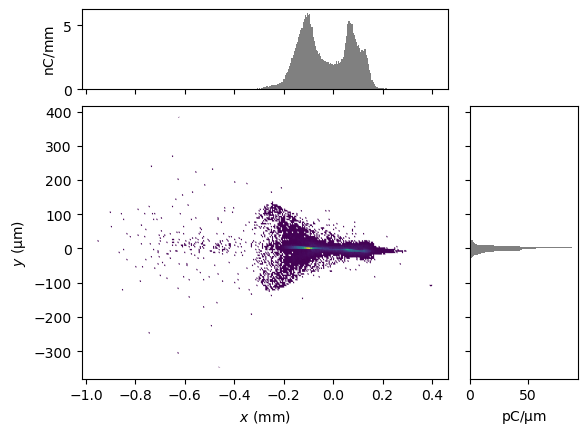

Witness:


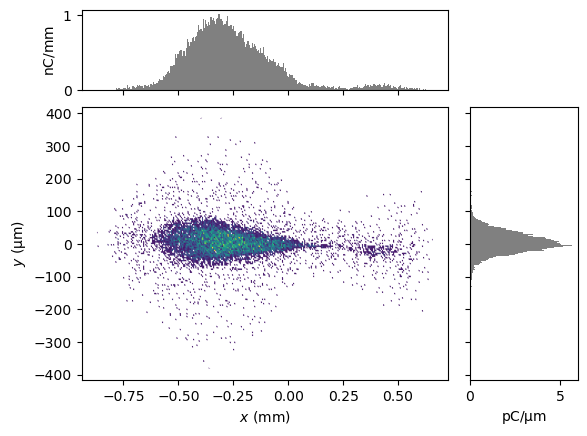

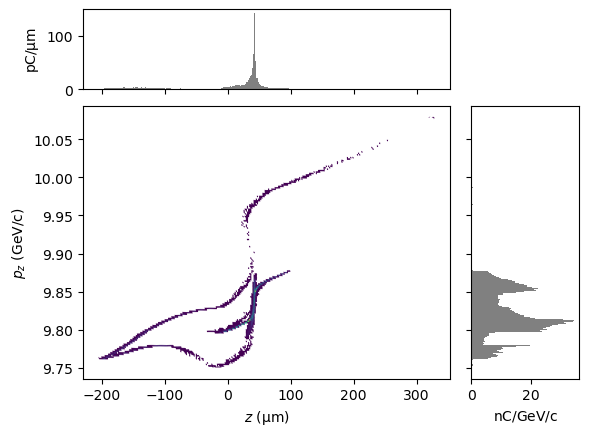

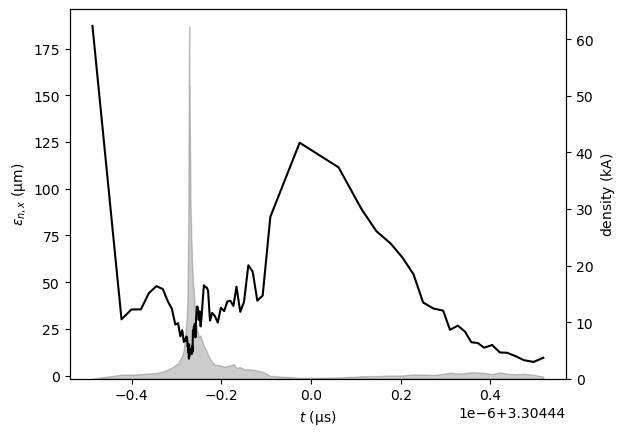

<Figure size 640x480 with 0 Axes>

In [7]:
print("Drive:")
display(plotMod(PDrive, 'x', 'y',  bins=300))
print("Witness:")
display(plotMod(PWitness, 'x', 'y',  bins=300))
display(plotMod(P, 'z', 'pz', bins=300))
#display(slicePlotMod(P, 'norm_emit_x', slice_key = "z", n_slice=100))
display(slicePlotMod(P, 'norm_emit_x', slice_key = "t", n_slice=100))
plt.clf()

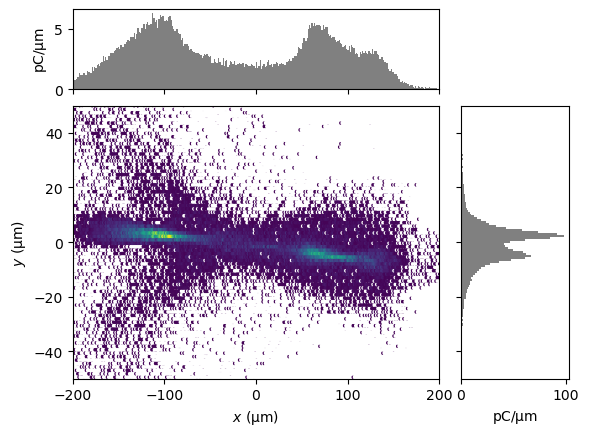

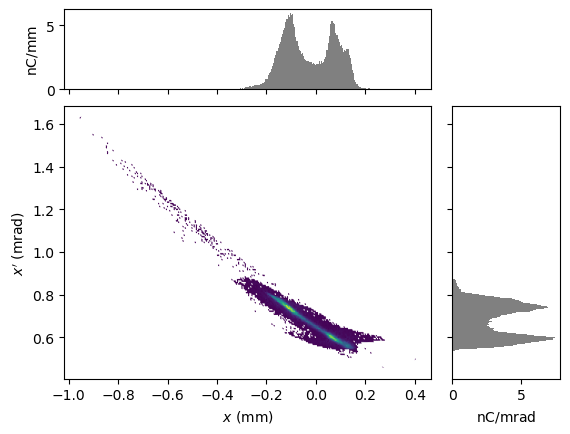

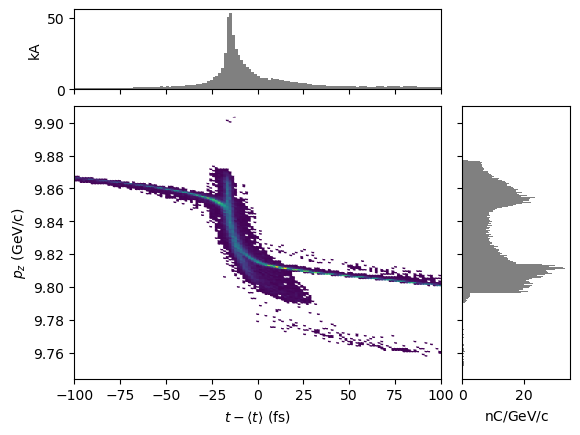

In [8]:
display(plotMod(PDrive, 'x', 'y', bins=1000, xlim = (-200e-6, 200e-6), ylim = (-50e-6, 50e-6)))
display(plotMod(PDrive, 'x', 'xp', bins=300))
display(plotMod(PDrive, 'delta_t', 'pz', bins=300, xlim = (-100e-15, 100e-15)))

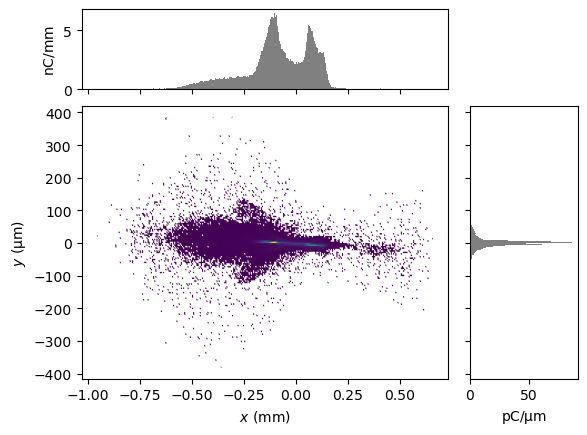

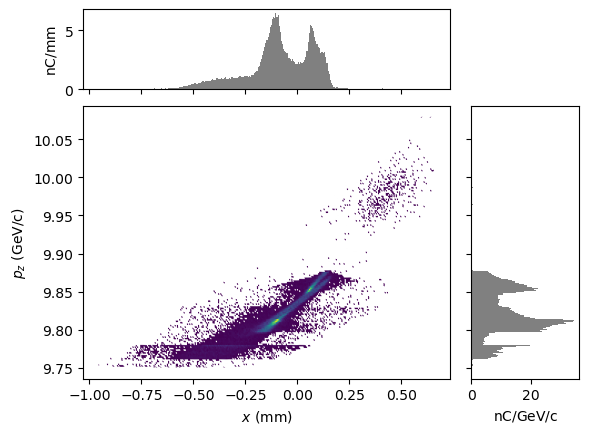

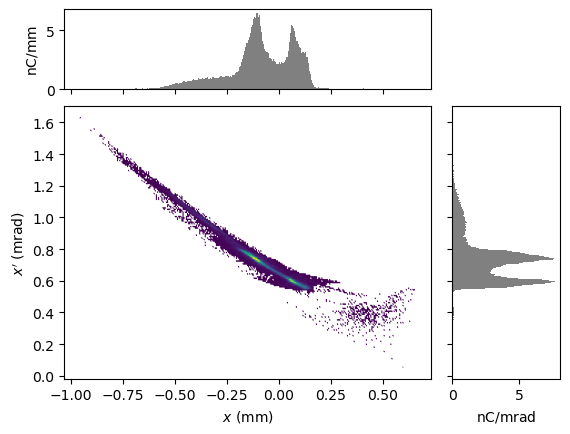

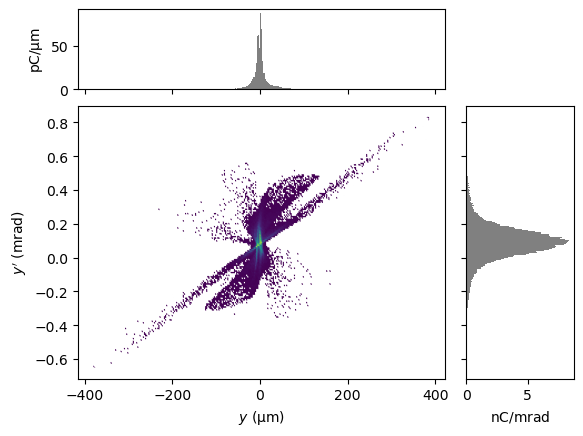

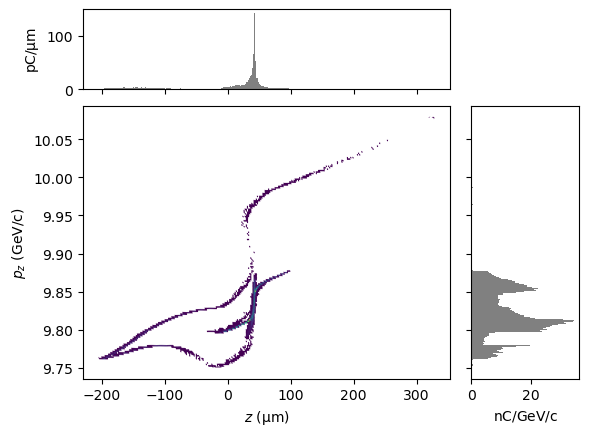

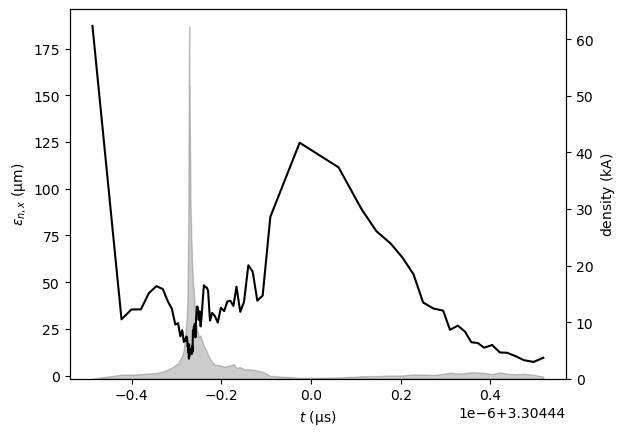

In [9]:
display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(P, 'x', 'pz', bins=300))
display(plotMod(P, 'x', 'xp', bins=300))
display(plotMod(P, 'y', 'yp', bins=300))
display(plotMod(P, 'z', 'pz', bins=300))
display(slicePlotMod(P, 'norm_emit_x',n_slice=100))

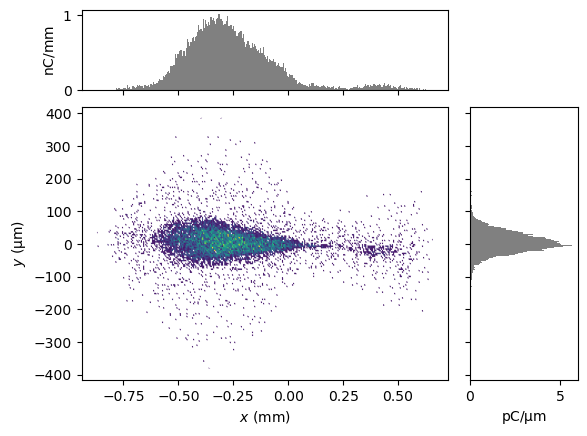

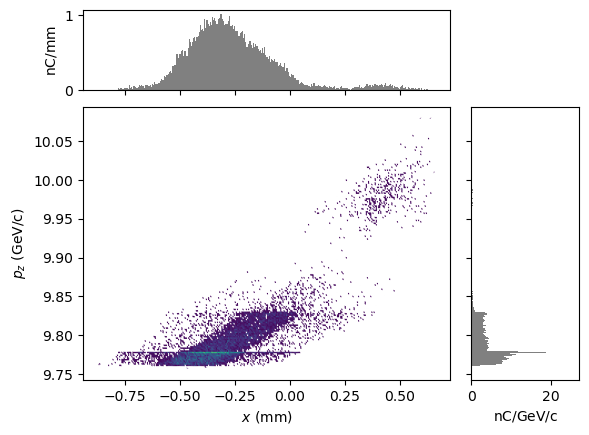

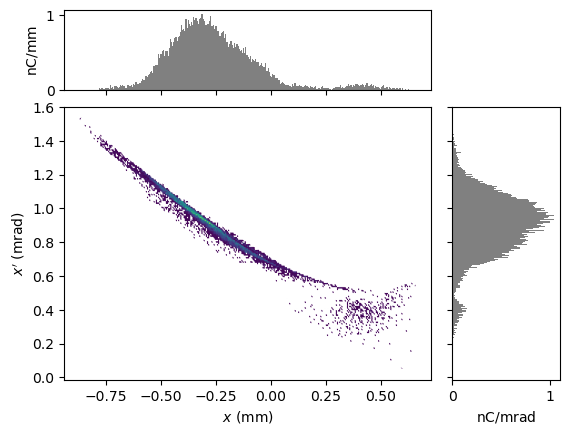

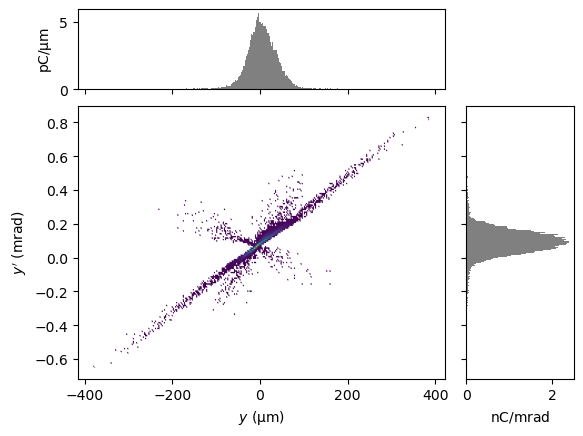

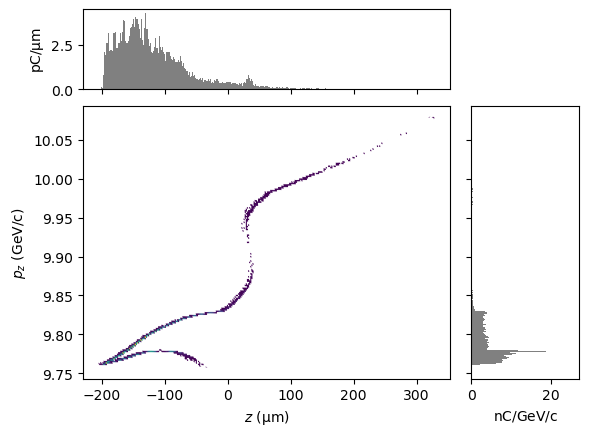

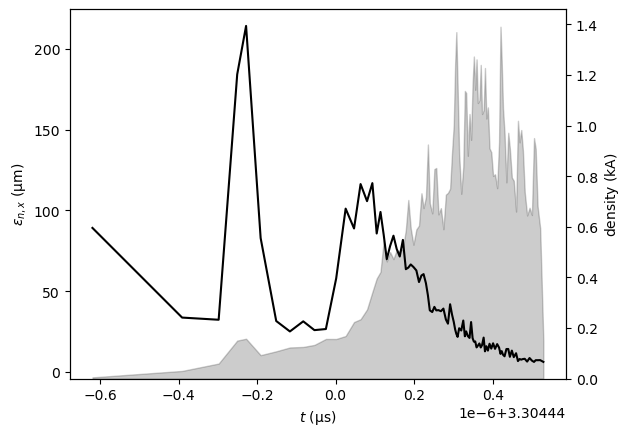

In [10]:
display(plotMod(PWitness, 'x', 'y',  bins=300))
display(plotMod(PWitness, 'x', 'pz', bins=300))
display(plotMod(PWitness, 'x', 'xp', bins=300))
display(plotMod(PWitness, 'y', 'yp', bins=300))
display(plotMod(PWitness, 'z', 'pz', bins=300))
display(slicePlotMod(PWitness, 'norm_emit_x',n_slice=100))


## Further study at other elements

In [11]:
?calcBMAG

Signature: calcBMAG(b0, a0, b, a)
Docstring: <no docstring>
File:      ~/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py
Type:      function

In [12]:
#def addBMAGToDict(dict, targetBeta, targetAlpha)

In [13]:
P = getBeamAtElement(tao, "PR10571")
PDrive, PWitness = getDriverAndWitness(P)


#PR10571 lucretia live model lattice 2024-10-16
targetBetaX = 5.7
targetBetaY = 2.6
targetAlphaX = -2.1
targetAlphaY = 0.0

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

System BMAG:  1.4323447678023977, 18.492468847652724
Drive BMAG:   2.0324434330254264, 30.270682906852677
Witness BMAG: 2.348107681799224, 22.44272094848029

System emit:  2.84624324524725e-06, 2.7790057727515734e-06
Drive emit:   2.04633872019384e-06, 1.9838943356532467e-06
Witness emit: 1.8194487984168902e-06, 1.7547409541109152e-06


In [14]:
P = getBeamAtElement(tao, "BEGBC20")
PDrive, PWitness = getDriverAndWitness(P)


#BEGBC20 lucretia live model lattice 2024-10-16
targetBetaX = 11.5
targetBetaY = 27.3
targetAlphaX = 0.7
targetAlphaY = 1.2

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)


print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print()

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

Drive beta x / y: 4.831039269993296, 201.34570070185381
Drive alpha x / y: 0.11975812741788482, 10.042950303656003

System BMAG:  1.1000331658399585, 2.821744302524917
Drive BMAG:   1.4364268758774712, 3.851865236857993
Witness BMAG: 3.7254502265215335, 6.652532633110491

System emit:  8.79261401864063e-06, 1.3887607503219924e-05
Drive emit:   3.829238106714788e-06, 1.1823264037104826e-05
Witness emit: 5.31140765130271e-06, 3.183985685070667e-06


In [15]:
P = getBeamAtElement(tao, "MFFF")
PDrive, PWitness = getDriverAndWitness(P)


#MFFF lucretia live model lattice 2024-10-16
targetBetaX = 11.6
targetBetaY = 25.2
targetAlphaX = -0.64
targetAlphaY = -1.6

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)


print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print()

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

Drive beta x / y: 2.456015555370887, 155.48005071895042
Drive alpha x / y: -0.031089265065024144, -9.965674067768337

System BMAG:  5.590362934508135, 1.7859913586218417
Drive BMAG:   2.49315808547804, 3.1666758953545813
Witness BMAG: 7.908069465766129, 2.7141211659891513

System emit:  3.064928815694484e-05, 1.550078523374599e-05
Drive emit:   6.811215071137482e-06, 1.0316893097887109e-05
Witness emit: 4.7722386003662e-05, 4.998354890482196e-06


In [16]:
P = getBeamAtElement(tao, "PENT")
PDrive, PWitness = getDriverAndWitness(P)

#PENT lucretia live model lattice 2024-10-16
targetBetaX = 0.5
targetBetaY = 0.5
targetAlphaX = 0.0
targetAlphaY = 0.0

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)

print(f"""System beta x / y: {PTwiss["beta_x"]}, {PTwiss["beta_y"]}""")
print(f"""System alpha x / y: {PTwiss["alpha_x"]}, {PTwiss["alpha_y"]}""")

print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print(f"""Witness beta x / y: {PWitnessTwiss["beta_x"]}, {PWitnessTwiss["beta_y"]}""")
print(f"""Witness alpha x / y: {PWitnessTwiss["alpha_x"]}, {PWitnessTwiss["alpha_y"]}""")

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

System beta x / y: 3.0384271618017817, 0.2572710993095606
System alpha x / y: 2.312731474872704, -0.6686874500116213
Drive beta x / y: 2.2618162696952058, 0.12115281583010244
Drive alpha x / y: 0.9764027272245718, -0.5067154881295781
Witness beta x / y: 5.98534861069026, 1.7688479385134266
Witness alpha x / y: 4.748375139801925, -3.4906268990015255
System BMAG:  3.5607966754338025, 1.6635142701192116
Drive BMAG:   2.477722653416949, 2.7144903649812577
Witness BMAG: 6.968878059009787, 3.63227495518416

System emit:  2.335287214355032e-05, 2.1294371100034514e-05
Drive emit:   6.696238667633827e-06, 1.2725028132529812e-05
Witness emit: 3.892851653288043e-05, 1.0491838420179642e-05


PR10571


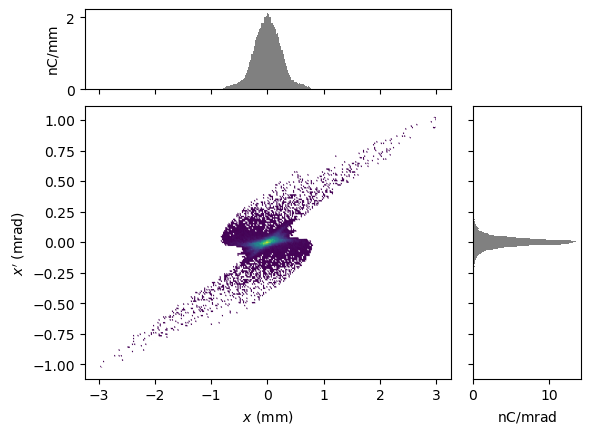

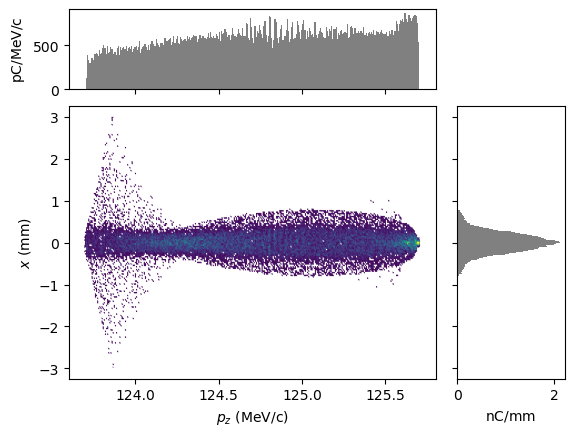

BEGBC20


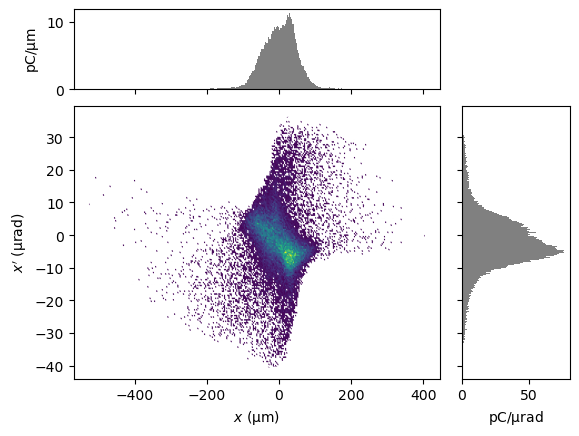

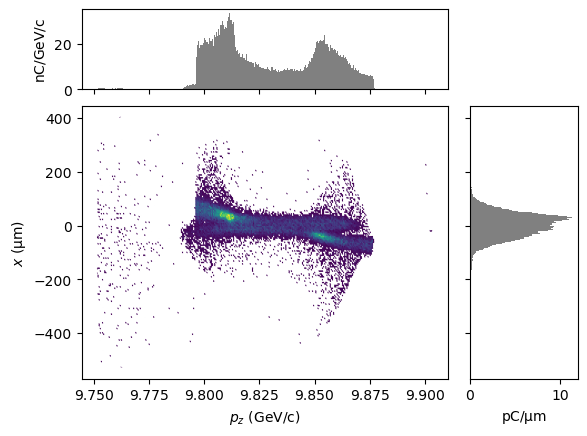

MFFF


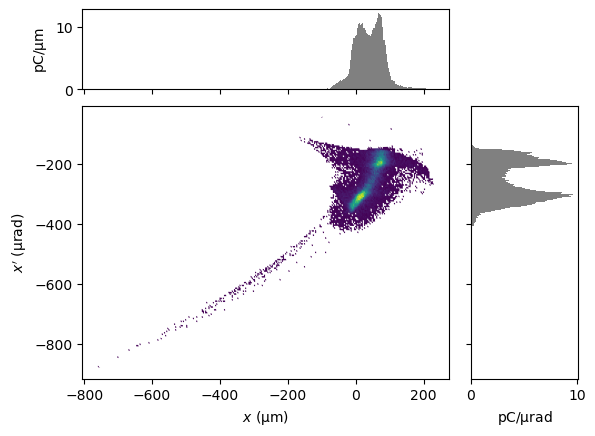

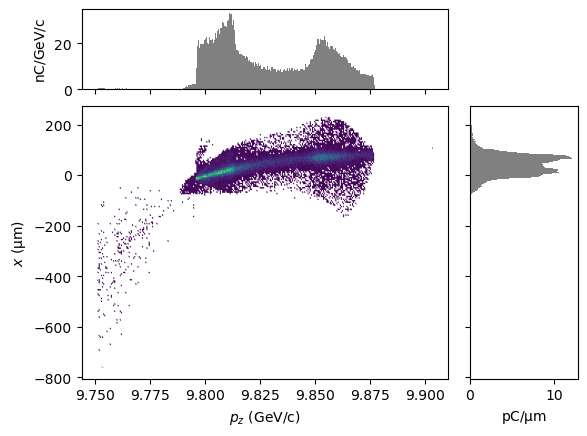

PENT


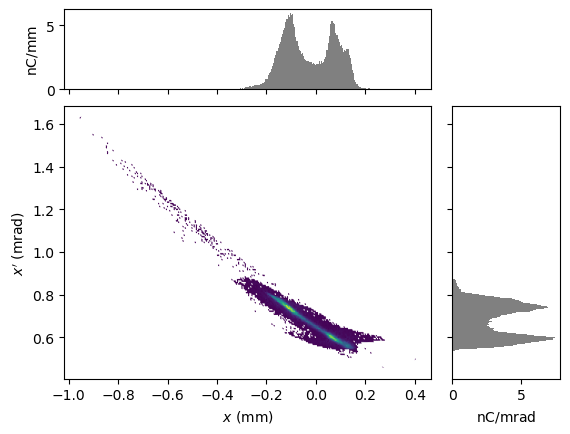

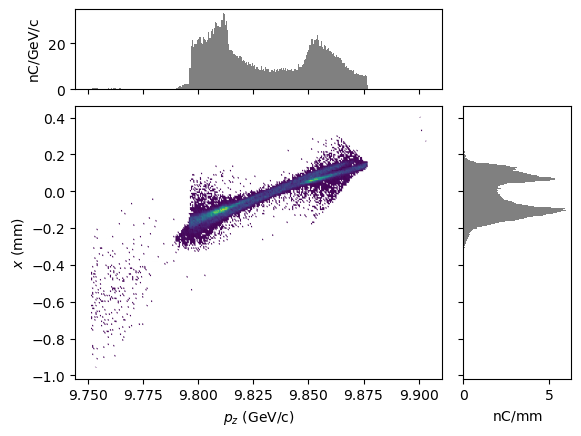

In [17]:

for activeElement in ["PR10571", "BEGBC20", "MFFF", "PENT"]:
    print(activeElement)
    P = getBeamAtElement(tao, activeElement)
    PDrive, PWitness = getDriverAndWitness(P)
    
    display(plotMod(PDrive, 'x', 'xp',  bins=300))
    display(plotMod(PDrive, 'pz', 'x',  bins=300))

# Comparing golden lattice to present lattice

In [18]:
# tao = initializeTao(loadDefaultLatticeTF=True)
# tao.cmd("show ele PENT")

In [19]:
# tao = initializeTao(loadDefaultLatticeTF=False)
# tao.cmd("show ele PENT")

In [20]:
# tao = initializeTao(loadDefaultLatticeTF=True)
# getMatrix(tao, "BEGBC20", "PENT", print = True);

# print()

# tao = initializeTao(loadDefaultLatticeTF=False)
# getMatrix(tao, "BEGBC20", "PENT", print = True);